
Processing Phishing-ALL
Selected features for Phishing-ALL: ['Internet Users (Millions)', 'Facebook Users (M)', 'LinkedIn Users (M)']
Iteration 1 out of 100


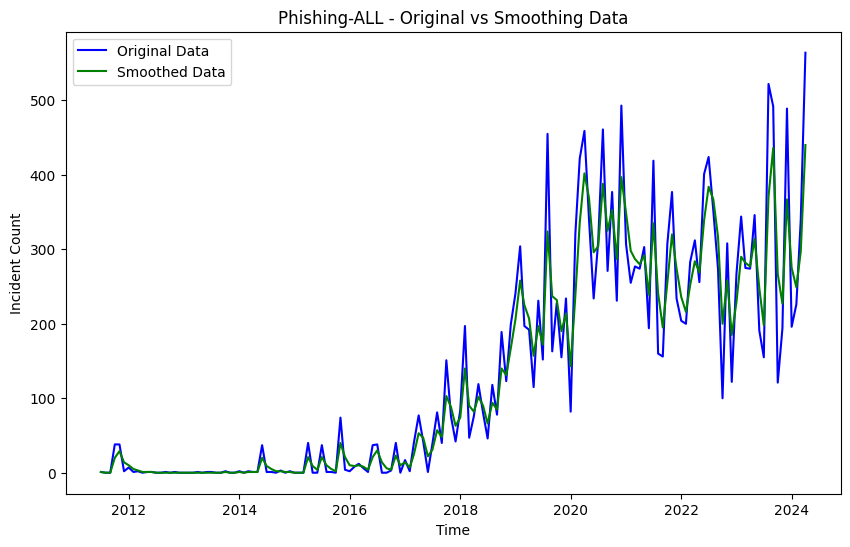


Top 5 Features by SHAP Impact:
TimeStep_1_Phishing-ALL: 0.7059
TimeStep_0_Phishing-ALL: 0.7031
TimeStep_2_Phishing-ALL: 0.6905
TimeStep_1_Facebook Users (M): 0.6828
TimeStep_2_Facebook Users (M): 0.6770


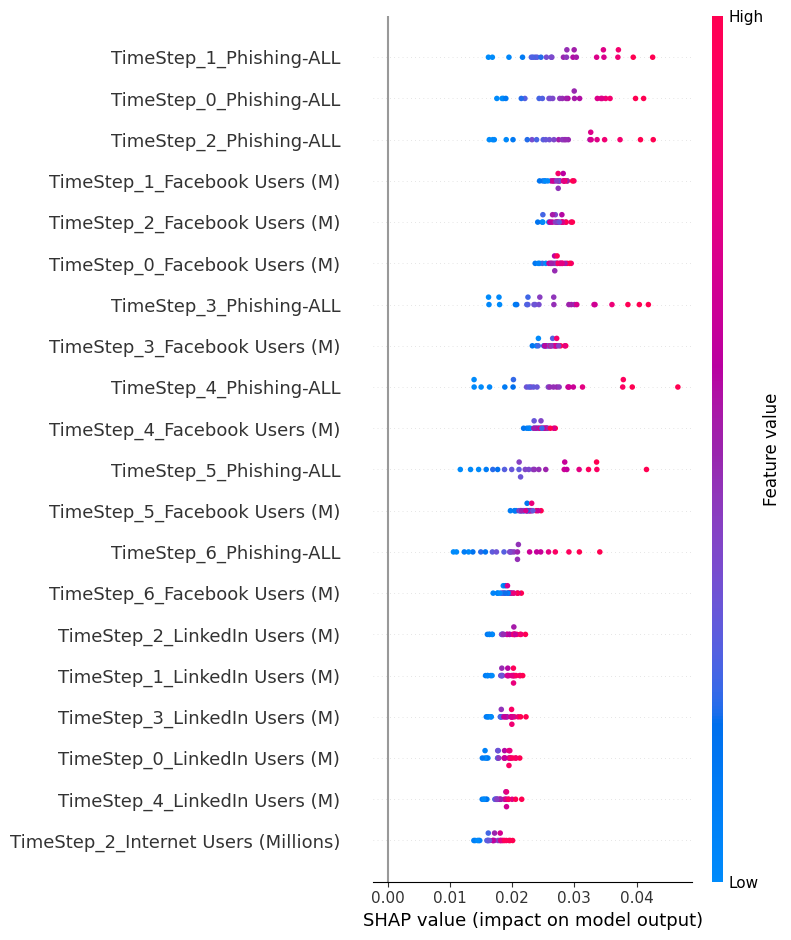

SHAP summary plot saved to output_plot_25M/shap_summary_plot.png.
Iteration 2 out of 100


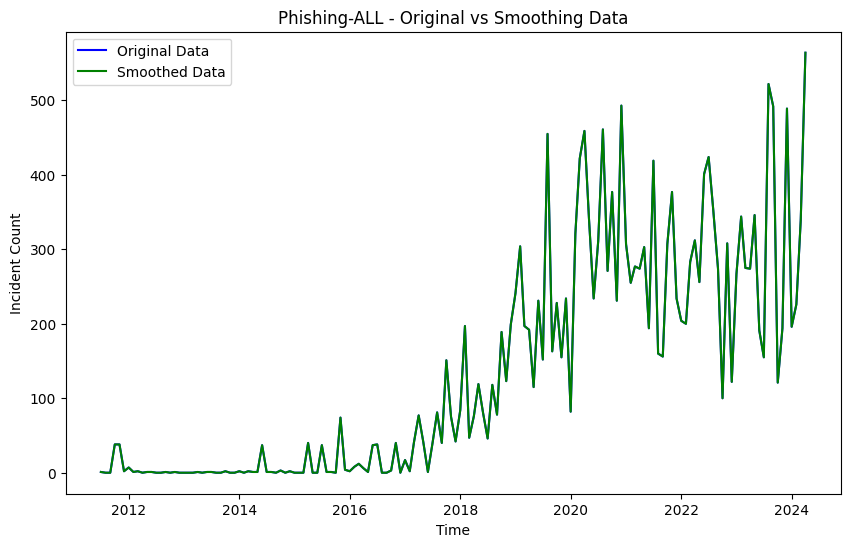

KeyboardInterrupt: 

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import matplotlib.pyplot as plt
import random
import json
import os
import shap

# SMAPE calculation function
def smape(yTrue, yPred):
    denominator = (np.abs(yTrue) + np.abs(yPred))
    return np.mean(200 * np.abs(yPred - yTrue) / denominator)

# Exponential Smoothing
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return np.array(result)

# Double Exponential Smoothing
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return np.array(result)

# Prepare multivariate data for LSTM input
def prepare_multivariate_data(data, n_input, n_features):
    X, y = [], []
    for i in range(len(data) - n_input):
        X.append(data[i:(i + n_input), :])
        y.append(data[i + n_input, -1])
    return np.array(X), np.array(y)

# Build the LSTM Model with Monte Carlo Dropout
def build_mc_dropout_model(n_input, n_features, layer, unit, dropout_rate, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=(n_input, n_features)))
    model.add(LSTM(unit[0], activation=activation, return_sequences=(layer > 1)))
    model.add(Dropout(dropout_rate))
    for i in range(1, layer):
        model.add(LSTM(unit[min(i, len(unit)-1)], activation=activation, return_sequences=(i < layer-1)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Monte Carlo Dropout prediction function
def mc_dropout_predict(model, X, n_iter=100):
    predictions = np.array([model(X, training=True) for _ in range(n_iter)])
    return predictions.mean(axis=0), predictions.std(axis=0)

def compute_and_plot_shap(model, train_x, test_x, n_input, n_features, features, output_dir):
    # Prepare the background dataset
    n_samples = min(100, train_x.shape[0])
    background = train_x[np.random.choice(train_x.shape[0], size=n_samples, replace=False)]
    
    # Initialize the SHAP GradientExplainer
    explainer = shap.GradientExplainer(model, background)

    # Compute SHAP values for the test set
    shap_values = explainer.shap_values(test_x)

    # Reshape shap_values and test_x for plotting
    shap_values_reshaped = shap_values.reshape(shap_values.shape[0], -1)
    test_x_reshaped = test_x.reshape(test_x.shape[0], -1)

    # Create feature names for each timestep and feature
    feature_names = []
    for i in range(n_input):
        for feature in features:  # Include the target variable here if necessary
            feature_names.append(f'TimeStep_{i}_{feature}')

    # Ensure the number of feature names matches the number of SHAP values
    assert shap_values_reshaped.shape[1] == len(feature_names), "Mismatch between SHAP values and feature names."

    # Aggregate the absolute SHAP values to calculate feature importance
    shap_values_abs = np.abs(shap_values_reshaped)
    feature_importance = np.sum(shap_values_abs, axis=0)

    # Create a dictionary of feature importance
    feature_importance_dict = {feature_names[i]: feature_importance[i] for i in range(len(feature_names))}

    # Sort features by importance
    sorted_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

    # Print the top N most important features (impact)
    print("\nTop 5 Features by SHAP Impact:")
    for feature, importance in sorted_importance[:5]:
        print(f"{feature}: {importance:.4f}")

    # Plot the SHAP summary plot
    shap.summary_plot(
        shap_values_reshaped,
        test_x_reshaped,
        feature_names=feature_names,
        show=False
    )

    # Save the plot
    shap_plot_path = os.path.join(output_dir, 'shap_summary_plot.png')
    plt.tight_layout()
    plt.savefig(shap_plot_path)
    plt.show()
    plt.close()
    print(f"SHAP summary plot saved to {shap_plot_path}.")

# Evaluate the model with Monte Carlo Dropout
def evaluate_mc_dropout_model(train, test, n_input, n_features, layer, unit, dropout_rate, scaler, epochs, features, output_dir, activation='relu', optimizer='adam'):
    train_x, train_y = prepare_multivariate_data(train, n_input, n_features)
    test_x, test_y = prepare_multivariate_data(test, n_input, n_features)
    
    model = build_mc_dropout_model(n_input, n_features, layer, unit, dropout_rate, activation=activation, optimizer=optimizer)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(train_x, train_y, epochs=epochs, batch_size=8, validation_split=0.2, callbacks=[es], verbose=0)
    
    predictions_mean, predictions_std = mc_dropout_predict(model, test_x)
    
    # Inverse transform predictions and actual values
    dummy_array = np.zeros((len(predictions_mean), n_features))
    dummy_array[:, -1] = predictions_mean.flatten()
    predictions_inv = scaler.inverse_transform(dummy_array)[:, -1]
    
    dummy_array[:, -1] = test_y
    y_test_inv = scaler.inverse_transform(dummy_array)[:, -1]
    
    # Calculate confidence intervals
    lower_bound = predictions_mean - 1.96 * predictions_std
    upper_bound = predictions_mean + 1.96 * predictions_std
    
    dummy_array[:, -1] = lower_bound.flatten()
    lower_bound_inv = scaler.inverse_transform(dummy_array)[:, -1]
    
    dummy_array[:, -1] = upper_bound.flatten()
    upper_bound_inv = scaler.inverse_transform(dummy_array)[:, -1]
    
    smape_value = smape(y_test_inv, predictions_inv)
    mae = mean_absolute_error(y_test_inv, predictions_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
    
    # Compute and plot SHAP values
    compute_and_plot_shap(model, train_x, test_x, n_input, n_features, features, output_dir)
    
    return smape_value, mae, rmse, predictions_inv, y_test_inv, lower_bound_inv, upper_bound_inv

# Boruta feature selection
def boruta_feature_selection(data, target_variable, features):
    X = data[features].values
    y = data[target_variable].values

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=42)
    
    boruta_selector.fit(X, y)
    
    selected_features = [features[i] for i in range(len(features)) if boruta_selector.support_[i]]
    
    if len(selected_features) >= 3:
        best_features = selected_features[:3]
    elif len(selected_features) >= 2:
        best_features = selected_features[:2]
    elif len(selected_features) >= 1:
        best_features = selected_features[:1]
    else:
        best_features = []
    
    return best_features

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    data = pd.read_csv('/Users/ashit/Documents/msc-projects-2023-4-aanand1304/Dataset/FinalDataset.csv')
    data['Date'] = pd.to_datetime(data['Date'], format='%b-%y')
    data.set_index('Date', inplace=True)

    attacks = ['Phishing-ALL', 'Ransomware-ALL', 'Password Attack-ALL', 'SQL Injection-ALL',
        'Account Hijacking-ALL', 'Defacement-ALL', 'Trojan-ALL', 'Vulnerability-ALL', 'Zero-day-ALL',
        'Malware-ALL', 'Advanced persistent threat-ALL', 'XSS-ALL', 'Data Breach-ALL',
        'Disinformation/Misinformation-ALL', 'Targeted Attack-ALL', 'Adware-ALL', 'Brute Force Attack-ALL',
        'Malvertising-ALL', 'Backdoor-ALL', 'Botnet-ALL', 'Cryptojacking-ALL', 'Worms-ALL', 'Spyware-ALL', 'DDoS-ALL',]

    features = [
    # Economic Data
    'GDP-ARE', 'GDP-AUS', 'GDP-AUT', 'GDP-BRA', 'GDP-CAN', 'GDP-CHE', 'GDP-CHN', 'GDP-DEU', 'GDP-EGY', 'GDP-ESP',
    'GDP-FIN', 'GDP-FRA', 'GDP-GBR', 'GDP-IND', 'GDP-IRL', 'GDP-IRN', 'GDP-ISR', 'GDP-ITA', 'GDP-JPN', 'GDP-KOR',
    'GDP-MEX', 'GDP-MYS', 'GDP-NLD', 'GDP-NOR', 'GDP-PAK', 'GDP-PRT', 'GDP-PSE', 'GDP-RUS', 'GDP-SAU', 'GDP-SWE',
    'GDP-TUR', 'GDP-UKR', 'GDP-USA',
    
    # Social Media and Internet Data
    'Internet Users (Millions)', 'Facebook Users (M)', 'Instagram Users (M)', 'Twitter Users (M)', 'LinkedIn Users (M)', 'Email Users (M)',
    
    # Holidays Data
    'Holidays',
    
    # Mentions
    'Mentions-DDoS', 'Mentions-Phishing', 'Mentions-Ransomware', 'Mentions-Password Attack', 'Mentions-SQL Injection',
    'Mentions-Account Hijacking', 'Mentions-Defacement', 'Mentions-Trojan', 'Mentions-Vulnerability', 'Mentions-Zero-day',
    'Mentions-Advanced persistent threat', 'Mentions-XSS', 'Mentions-Malware', 'Mentions-Data Breach', 'Mentions-Disinformation/Misinformation',
    'Mentions-Targeted Attack', 'Mentions-Adware', 'Mentions-Brute Force Attack', 'Mentions-Malvertising', 'Mentions-Backdoor',
    'Mentions-Botnet', 'Mentions-Cryptojacking', 'Mentions-Worms', 'Mentions-Spyware', 'Mentions-MITM', 'Mentions-DNS Spoofing',
    'Mentions-Pegasus Spyware', 'Mentions-CoolWebSearch Spyware', 'Mentions-Gator GAIN Spyware', 'Mentions-180search Assistant Spyware',
    'Mentions-Transponder vx2 Spyware', 'Mentions-WannaCry Ransomware', 'Mentions-Colonial Pipeline Ransomware', 'Mentions-Cryptolocker',
    'Mentions-Dropper', 'Mentions-Wiper', 'Mentions-Pharming', 'Mentions-Insider Threat', 'Mentions-Drive-by', 'Mentions-Rootkit',
    'Mentions-Adversarial Attack', 'Mentions-Data Poisoning', 'Mentions-Deepfake', 'Mentions-Deeplocker', 'Mentions-Supply Chain',
    'Mentions-IoT Device Attack', 'Mentions-Keylogger', 'Mentions-DNS Tunneling', 'Mentions-Session Hijacking', 'Mentions-URL manipulation',
    'Mentions-Unknown'

    ]

    output_dir = 'best_params_files_M'
    output_plot_dir = 'output_plot_M'
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(output_plot_dir, exist_ok=True)

    for target_variable in attacks:
        print(f"\nProcessing {target_variable}")
        
        # Perform Boruta feature selection
        selected_features = boruta_feature_selection(data, target_variable, features)
        
        if not selected_features:
            print(f"No significant features found for {target_variable}. Skipping this target.")
            continue
        
        print(f"Selected features for {target_variable}: {selected_features}")
        
        # Include the target variable in the selected features
        selected_features = selected_features + [target_variable]
        
        selected_data = data[selected_features].values
        
        best_smape = float('inf')
        best_params = {}
        
        iterations = 100

        for iteration in range(iterations):
            print(f"Iteration {iteration+1} out of {iterations}")

            # Apply smoothing to the target variable
            alpha = random.uniform(0.1, 0.9)
            beta = random.uniform(0.1, 0.9)
            smoothing_method = random.choice(['none', 'exponential', 'double_exponential'])
            data_copy = selected_data.copy()
            if smoothing_method == 'exponential':
                data_copy[:, -1] = exponential_smoothing(data_copy[:, -1], alpha)
            elif smoothing_method == 'double_exponential':
                data_copy[:, -1] = double_exponential_smoothing(data_copy[:, -1], alpha, beta)

            # Plot data before and after smoothing on the same graph
            original_target = selected_data[:, -1].copy()
            plt.figure(figsize=(10, 6))
            plt.plot(data.index, original_target, label='Original Data', color='blue')
            plt.plot(data.index, data_copy[:, -1], label='Smoothed Data', color='green')
            plt.title(f'{target_variable} - Original vs Smoothing Data')
            plt.xlabel('Time')
            plt.ylabel('Incident Count')
            plt.legend()
            plt.show()

            # Scale the data
            scaler = MinMaxScaler()
            scaled_data = scaler.fit_transform(data_copy)

            # Split the data
            train_size = len(scaled_data) - 36
            train, test = scaled_data[:train_size], scaled_data[train_size:]
            test_dates = data.index[train_size:]

            n_input = random.randint(1, 12)
            n_epochs = random.choice([100, 200, 300, 400, 500])
            layer = random.choice([1, 2, 3])
            dropout_rate = random.uniform(0.1, 0.15)
            activation_function = random.choice(['relu', 'tanh'])
            optimizer_choice = random.choice(['adam', 'rmsprop'])

            if layer == 1:
                units = [random.choice([16, 32])]
            elif layer == 2:
                units = [random.choice([100, 200]), random.choice([50, 100])]
            else:
                units = [random.choice([200, 400]), random.choice([100, 200]), random.choice([50, 100])]

            smape_value, mae, rmse, predictions, y_test_inv, lower_bound, upper_bound = evaluate_mc_dropout_model(
                train, test, n_input, len(selected_features), layer, units, dropout_rate, scaler, n_epochs, selected_features, output_plot_dir,
                activation=activation_function, optimizer=optimizer_choice
            )

            if smape_value < best_smape:
                best_smape = smape_value
                best_params = {
                    'n_input': n_input,
                    'n_epochs': n_epochs,
                    'layer': layer,
                    'units': units,
                    'dropout_rate': dropout_rate,
                    'smoothing_method': smoothing_method,
                    'alpha': alpha,
                    'beta': beta,
                    'selected_features': selected_features
                }
                best_predictions = predictions
                best_y_test_inv = y_test_inv
                best_lower_bound = lower_bound
                best_upper_bound = upper_bound

        # Save the best parameters
        file_path = os.path.join(output_dir, f'{target_variable}_best_params.json')
        data_to_save = {
            "SMAPE": best_smape,
            "Best Parameters": best_params
        }
        with open(file_path, 'w') as f:
            json.dump(data_to_save, f)
        print(f"Best parameters for {target_variable} saved to {file_path}.")
        print(f"Best SMAPE for {target_variable}: {best_smape}")
        print(f"Best MAE: {mae}")
        print(f"Best RMSE: {rmse}")

        # Plot the actual vs predicted values with confidence interval
        plt.figure(figsize=(12, 6))
        plt.plot(test_dates[-len(best_y_test_inv):], best_y_test_inv, label='Actual', color='blue', linewidth=2)
        plt.plot(test_dates[-len(best_predictions):], best_predictions, label='Predicted', color='red', linewidth=2)
        plt.fill_between(test_dates[-len(best_predictions):], best_lower_bound, best_upper_bound, color='green', alpha=0.2, label='95% CI')
        plt.title(f'{target_variable} (SMAPE: {best_smape:.2f}, Multivariate)')
        plt.xlabel('Time')
        plt.ylabel('Incident Count')
        plt.legend()
        plot_path = os.path.join(output_plot_dir, f'{target_variable}_actual_vs_predicted_mc_smoothed.png')
        plt.savefig(plot_path)
        plt.show()
        plt.close()
        print(f"Plot for {target_variable} saved to {plot_path}.")